In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix,f1_score
from tensorflow import keras
import cv2
from keras.applications.vgg16 import VGG16
import keras_tuner as kt
import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
np.random.seed(42)
tf.random.set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Retrieving all the files name using glob.glob function<h3>

In [2]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [3]:
len(breast_img)

277524

In [4]:
breast_img[5:10]

['/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_class0.png']

<h3>Extracting images in arrays of arrays format and equalizing the number of cancerous and non- cancerous<h3>


In [5]:
data=[]
label=[]
c=0
b=0
for i in breast_img:
      a=cv2.imread(i,cv2.IMREAD_COLOR)
      a=cv2.resize(a, (224, 224), interpolation = cv2.INTER_LINEAR)
      if i[-5]=='0' and b<=20000:
        label.append(0)
        data.append(a)
        b+=1
      elif  i[-5]=='1' and c<=20000:
        label.append(1)
        data.append(a) 
        c+=1
     
      if b>=20000 and c>=20000:
        break
        

In [6]:
data=np.array(data)
label=np.array(label)

<h4>Shape of our data<h4>

In [7]:
data.shape,label.shape

((40001, 224, 224, 3), (40001,))

In [8]:
data[10],label[10]

(array([[[183, 144, 221],
         [183, 144, 221],
         [183, 144, 221],
         ...,
         [177, 140, 215],
         [177, 141, 215],
         [177, 141, 215]],
 
        [[183, 144, 221],
         [183, 144, 221],
         [183, 144, 221],
         ...,
         [177, 140, 215],
         [177, 141, 215],
         [177, 141, 215]],
 
        [[183, 144, 221],
         [183, 144, 221],
         [183, 145, 221],
         ...,
         [177, 140, 215],
         [177, 141, 215],
         [177, 141, 215]],
 
        ...,
 
        [[156, 109, 212],
         [156, 109, 212],
         [157, 110, 212],
         ...,
         [191, 157, 221],
         [192, 158, 222],
         [192, 158, 222]],
 
        [[156, 109, 212],
         [156, 109, 212],
         [157, 109, 211],
         ...,
         [192, 157, 222],
         [192, 158, 222],
         [192, 158, 222]],
 
        [[156, 109, 212],
         [156, 109, 212],
         [157, 110, 211],
         ...,
         [192, 157, 222],
  

<h4>Number of cancerous and non-cancerous patients<h4>

In [9]:
unique_values, counts = np.unique(label, return_counts=True)
for i in range(len(counts)):
  print(unique_values[i],counts[i])

0 20001
1 20000


In [10]:
unique_values=['Non IDC','IDC']


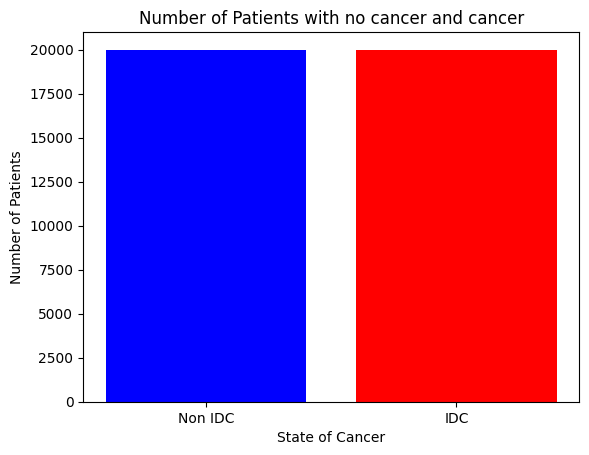

In [11]:
plt.bar(unique_values,counts,color=['Blue','red'])
# Adding labels and a title
plt.xlabel('State of Cancer')
plt.ylabel('Number of Patients')
plt.title('Number of Patients with no cancer and cancer')

# Display the bar chart
plt.show()

<h4>Display of some images data<h4>

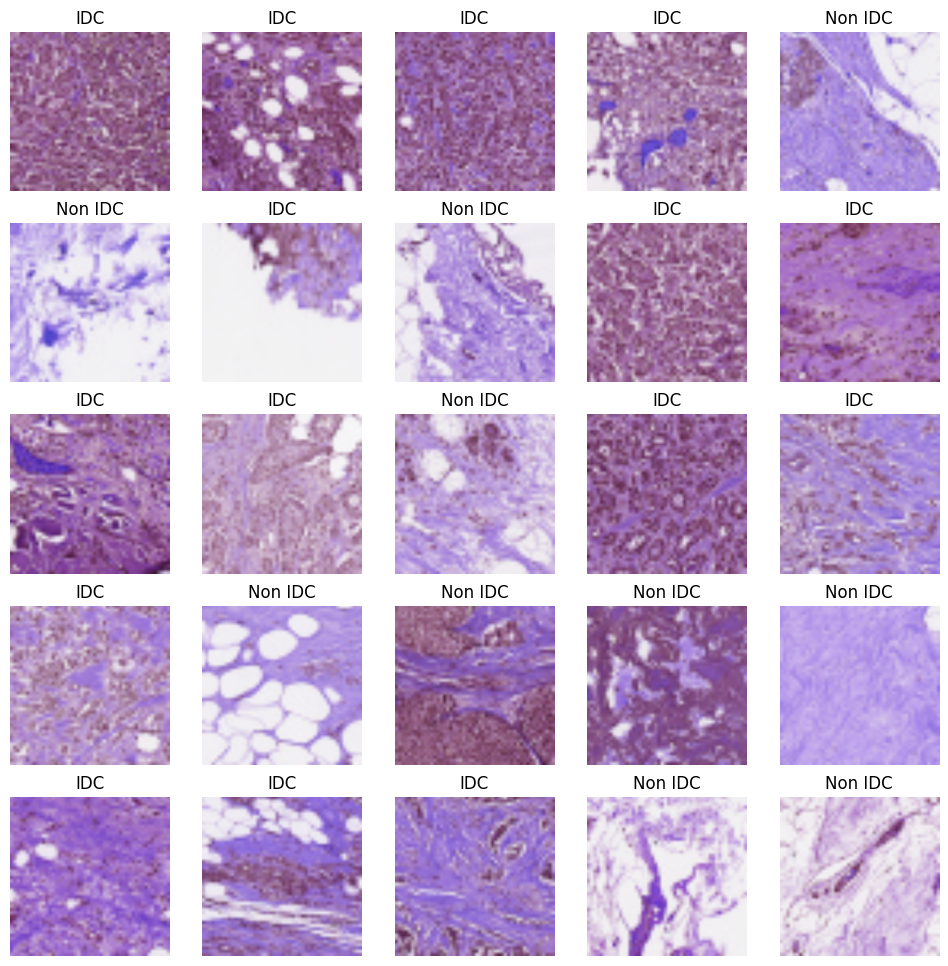

In [12]:
# Create a figure with 5 rows and 5 columns to display 25 images
sh = np.random.randint(0, len(label),25)
fig = plt.figure(figsize=(12, 12))
s=1
for i in sh:
    plt.subplot(5, 5, s)
    plt.imshow(data[i])
    if label[i]==0:
     plt.title('Non IDC')
    else:
     plt.title('IDC')
    plt.axis('off')
    s+=1


# Show the plot
plt.show()

<h4>Splitting the data into test and train<h4>

In [13]:
x_train,x_test,y_train,y_test=train_test_split(data,label,random_state=78,test_size=0.25)

In [14]:
unique_values, counts = np.unique(y_test, return_counts=True)
for i in range(len(counts)):
  print(unique_values[i],counts[i])

0 5012
1 4989


In [15]:
x_test.shape,y_train.shape


((10001, 224, 224, 3), (30000,))

<h4> Converting categorical data into a one-hot encoded format,One-hot encoding is a way to represent categorical variables with binary vectors.<h4>

In [16]:
y_train=tf.one_hot(y_train,2)
y_test=tf.one_hot(y_test,2)

In [17]:
y_train

<tf.Tensor: shape=(30000, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

<h3>Using VGG16 Model<h3>

In [18]:
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])


In [21]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history1=model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 75)

Epoch 1/10
400/400 [==============================] - 182s 409ms/step - loss: 0.5028 - accuracy: 0.7961 - val_loss: 0.3867 - val_accuracy: 0.8315
Epoch 2/10
400/400 [==============================] - 170s 426ms/step - loss: 0.3809 - accuracy: 0.8315 - val_loss: 0.3650 - val_accuracy: 0.8415
Epoch 3/10
400/400 [==============================] - 177s 442ms/step - loss: 0.3303 - accuracy: 0.8514 - val_loss: 0.3616 - val_accuracy: 0.8470
Epoch 4/10
400/400 [==============================] - 178s 445ms/step - loss: 0.2888 - accuracy: 0.8697 - val_loss: 0.3627 - val_accuracy: 0.8415
Epoch 5/10
400/400 [==============================] - 178s 445ms/step - loss: 0.2601 - accuracy: 0.8772 - val_loss: 0.3778 - val_accuracy: 0.8490
Epoch 6/10
400/400 [==============================] - 178s 445ms/step - loss: 0.2339 - accuracy: 0.8875 - val_loss: 0.3973 - val_accuracy: 0.8459
Epoch 7/10
400/400 [==============================] - 178s 444ms/step - loss: 0.2186 - accuracy: 0.8924 - val_loss: 0.3949 -

In [23]:
y_pred=model.predict(x_test)
y_pred_max=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis = 1)

313/313 [==============================] - 51s 146ms/step


<h3>All Metrics<h3>

In [24]:
accuracy1=accuracy_score(y_true,y_pred_max)
precision1=precision_score(y_true,y_pred_max)
recall1=recall_score(y_true,y_pred_max)
f1score1=f1_score(y_true,y_pred_max)

In [25]:
print("Precision is:",precision1)
print("Accuracy is:",accuracy1)
print("Recall is:",recall1)
print("F1 Score is:",f1score1)

Precision is: 0.8457015409570154
Accuracy is: 0.8421157884211579
Recall is: 0.8360392864301464
F1 Score is: 0.8408426569902226


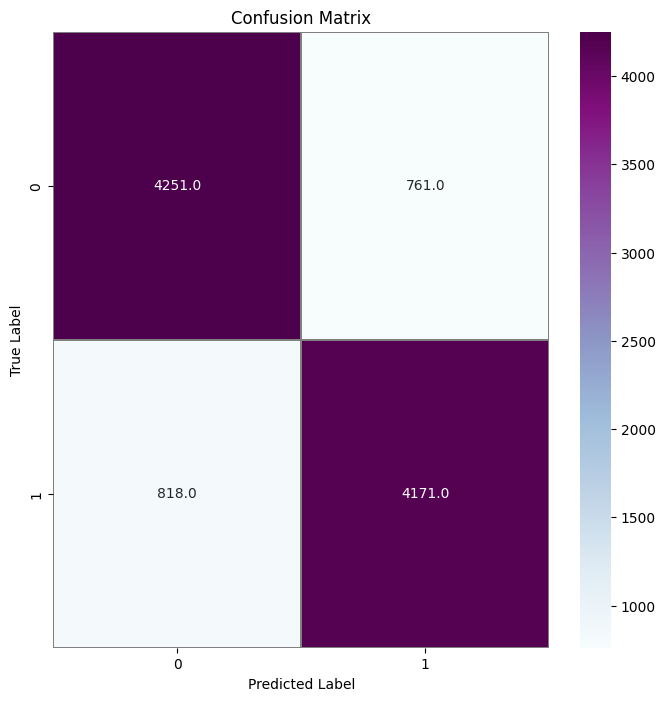

In [26]:
confusion_mtx = confusion_matrix(y_true, y_pred_max) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

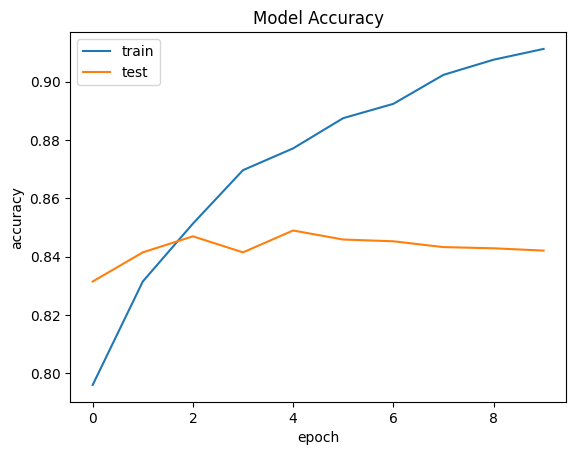

In [27]:
#Plotting training and validation accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

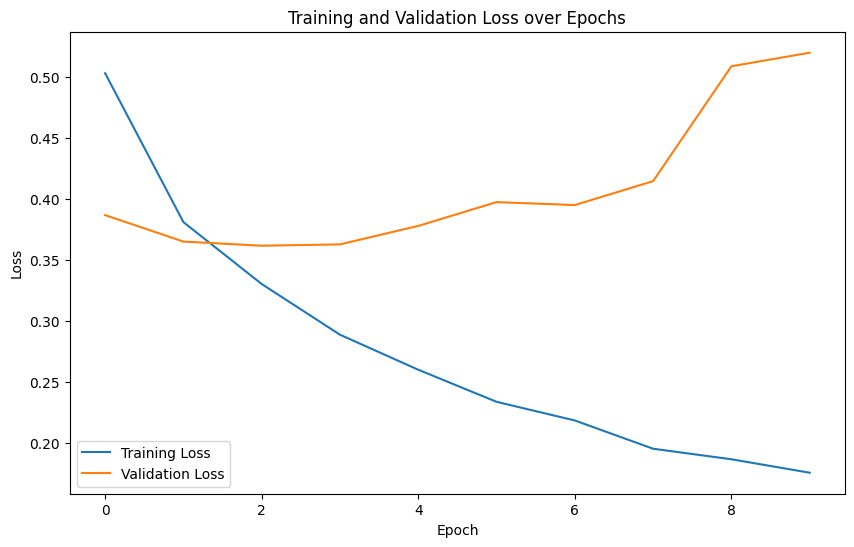

In [28]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h3>Using keras-tuner to improve accuracy<h3>

In [29]:
def build_model(hp):
    model = keras.Sequential()
    c=0
    # Add convolutional layers
    for i in range(hp.Int('convolayer', 3, 8)):
        if c == 0:
            model.add(keras.layers.Conv2D(filters=hp.Int('Filter' + str(i), 32,128, step=32),
                                          kernel_size=3,
                                          padding='same',
                                          activation='relu',
                                          input_shape=(224, 224, 3)))
            model.add(keras.layers.MaxPooling2D((2, 2),padding="VALID",strides =2))
        else:
            model.add(keras.layers.Conv2D(filters=hp.Int('Filter' + str(i), 32, 128, step=32),
                                          kernel_size=3,
                                          padding='same',
                                          activation='relu'))
            model.add(keras.layers.MaxPooling2D((2, 2),padding="VALID",strides =2))

        c=c+1
    model.add(keras.layers.Flatten())
    # Add dense layers with dropouts

    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))    
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(2, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [30]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [31]:
tuner.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Trial 5 Complete [00h 04m 11s]
val_accuracy: 0.7903209924697876

Best val_accuracy So Far: 0.832716703414917
Total elapsed time: 00h 16m 09s


In [32]:
best_hyperparameter = tuner.get_best_hyperparameters()[0].values
best_hyperparameter

{'convolayer': 7,
 'Filter0': 32,
 'Filter1': 96,
 'Filter2': 96,
 'Filter3': 32,
 'Filter4': 32,
 'Filter5': 32,
 'Filter6': 32}

In [33]:
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 96)      27744     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 96)        83040     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 96)        0

In [34]:
history2=best_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, initial_epoch=5, batch_size = 75)

Epoch 6/20
400/400 [==============================] - 59s 132ms/step - loss: 0.3777 - accuracy: 0.8361 - val_loss: 0.3595 - val_accuracy: 0.8428
Epoch 7/20
400/400 [==============================] - 49s 123ms/step - loss: 0.3714 - accuracy: 0.8397 - val_loss: 0.3709 - val_accuracy: 0.8450
Epoch 8/20
400/400 [==============================] - 49s 123ms/step - loss: 0.3674 - accuracy: 0.8414 - val_loss: 0.3565 - val_accuracy: 0.8461
Epoch 9/20
400/400 [==============================] - 49s 124ms/step - loss: 0.3679 - accuracy: 0.8417 - val_loss: 0.3660 - val_accuracy: 0.8461
Epoch 10/20
400/400 [==============================] - 49s 124ms/step - loss: 0.3595 - accuracy: 0.8454 - val_loss: 0.3547 - val_accuracy: 0.8458
Epoch 11/20
400/400 [==============================] - 50s 124ms/step - loss: 0.3555 - accuracy: 0.8466 - val_loss: 0.3721 - val_accuracy: 0.8417
Epoch 12/20
400/400 [==============================] - 49s 124ms/step - loss: 0.3489 - accuracy: 0.8526 - val_loss: 0.3466 - val

In [35]:
y_pred=best_model.predict(x_test)
y_pred_max=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis = 1)

313/313 [==============================] - 4s 13ms/step


In [36]:
accuracy2=accuracy_score(y_true,y_pred_max)
precision2=precision_score(y_true,y_pred_max)
recall2=recall_score(y_true,y_pred_max)
f1score2=f1_score(y_true,y_pred_max)

In [37]:
print("Precision is:",precision2)
print("Accuracy is:",accuracy2)
print("Recall is:",recall2)
print("F1 Score is:",f1score2)

Precision is: 0.8570839348319241
Accuracy is: 0.8474152584741526
Recall is: 0.8330326718781319
F1 Score is: 0.8448871721894694


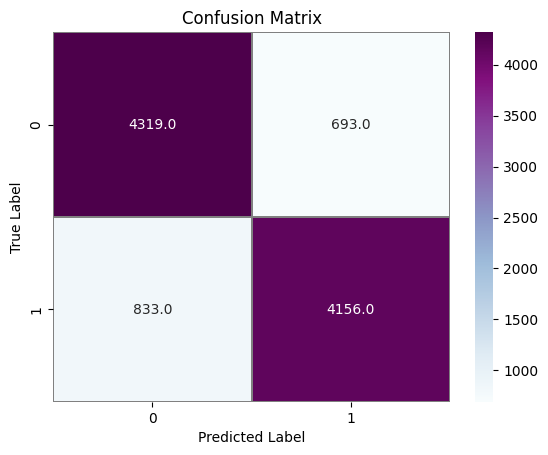

In [38]:
confusion_mtx = confusion_matrix(y_true,y_pred_max)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


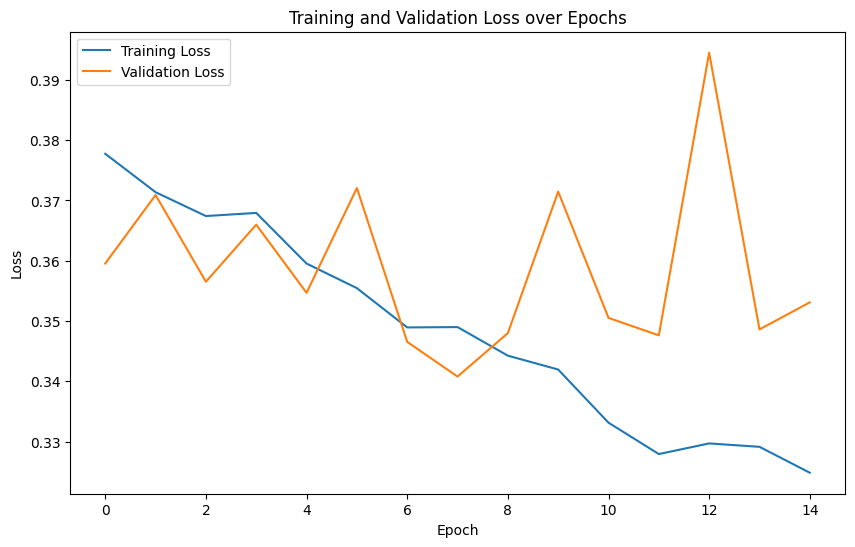

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

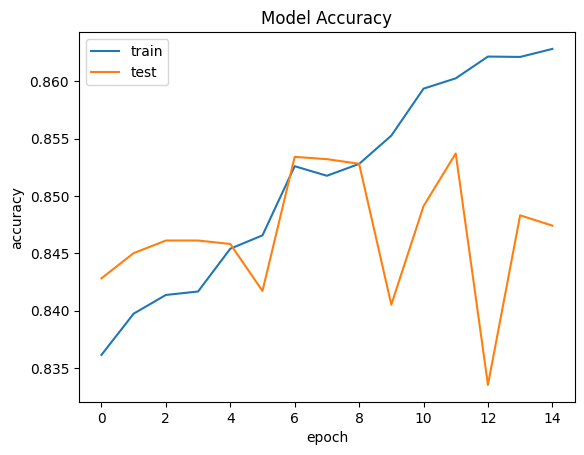

In [40]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()